## Experiment 2b: Comparative Analysis of XAI Methods (`ImageNet`)

**Selected Methods**
- Vanilla Gradients (Saliency)
- Integrated Gradients (IG)
- SHAP

In [120]:
import gc
import copy
import pandas as pd
import seaborn as sns

import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
import quantus
import captum

%matplotlib inline

In [121]:
torch.cuda.empty_cache()
gc.collect()

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42; mpl.rcParams['ps.fonttype']  = 42

# Reproducibility
torch.manual_seed(0); np.random.seed(0); random.seed(0)

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load `ImageNet` Dataset samples
This subset of ImageNet contains:
  - `x_batch` ... images
  - `y_batch` ... labels
  - `s_batch` ... segmentation masks (required by Localization metrics)

In [123]:
# Load data
x_batch = torch.load("imagenet50-samples/x_batch.pt").to(device)
y_batch = torch.load("imagenet50-samples/y_batch.pt").to(device)
s_batch = torch.load("imagenet50-samples/s_batch.pt").to(device)

print(f"{len(x_batch)} matches found.")

500 matches found.


In [124]:
class_to_index = torch.load("imagenet50-samples/class_to_index.pt")
with open('imagenet50-samples/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f]
index_to_label = dict(enumerate(labels))

In [125]:
# Ensure segmentation masks have a singleton channel dimension.
if s_batch.dim() == 3:  # (N, H, W)  ->  (N, 1, H, W)
    s_batch = s_batch.unsqueeze(1)

num_samples = len(x_batch)
print(f"{num_samples} samples loaded.")

500 samples loaded.


In [126]:
torch.manual_seed(777)
# NOTE: Select subset (large subset sizes are computationally heavy)
indices = torch.randperm(num_samples)[:10] 

x_batch = x_batch[indices].to(device) # (30, 3, 224, 224)
y_batch = y_batch[indices].to(device) # (30,)
s_batch = s_batch[indices].to(device) # (30, 1, 224, 224)
s_batch.shape

torch.Size([10, 1, 224, 224])

### Display sample images

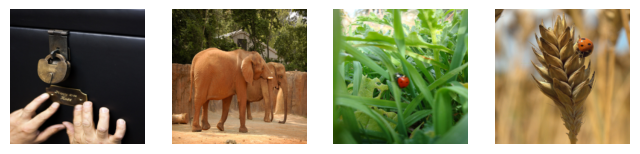

In [127]:
nr_images = 4 # number of images to display
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*2, int(nr_images)))

for i in range(nr_images):
    img = quantus.normalise_func.denormalise(
        x_batch[i].cpu().numpy(), 
        mean=np.array([0.485, 0.456, 0.406]), 
        std=np.array([0.229, 0.224, 0.225])
    )
    img = np.clip(img, 0.0, 1.0)
    axes[i].imshow(np.moveaxis(img, 0, -1), vmin=0.0, vmax=1.0)
    axes[i].axis("off")
plt.show()

### Load `ResNet50` model
- pretrained on ImageNet

In [128]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1).to(device)

In [129]:
# Get indices of correct predictions
with torch.no_grad():
    outputs = model(x_batch)
    predictions = torch.argmax(outputs, dim=1)
 
# Find indices where predictions match ground truth
correct_indices = torch.where(predictions == y_batch)[0]
print(f"Found {len(correct_indices)} correct predictions out of {len(x_batch)} samples")

Found 7 correct predictions out of 10 samples


### Calculate attributions for the selected methods

In [130]:
def explain_in_chunks(method, x, y, chunk=4, **kwargs):
    """Compute attributions in batches to manage memory usage."""
    out = []
    for i in range(0, len(x), chunk):
        attr = quantus.explain(
            model,
            x[i:i+chunk],
            y[i:i+chunk],
            method=method,
            n_steps=32,             # keep path resolution
            internal_batch_size=1,  # shard interpolation steps
            device=device,
            **kwargs
        )
        out.append(attr)       
        torch.cuda.empty_cache()    # release activations
    return np.concatenate([x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in out])

In [131]:
# Specify layer of the ResNet for Guided Grad-CAM method
target_layer = model.layer4[-1].conv3
layer_arg = {"gc_layer": target_layer} 

explanations = {
    "Gradient":           explain_in_chunks("Gradient",            x_batch, y_batch, chunk=16),
    "IntegratedGradients":explain_in_chunks("IntegratedGradients", x_batch, y_batch, chunk=2),
    "GradientShap":       explain_in_chunks("GradientShap",        x_batch, y_batch, chunk=2),
    "GuidedGradCam":      explain_in_chunks("GuidedGradCam",       x_batch, y_batch, chunk=2, **layer_arg)
}

c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:63: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


### Evaluation with [Quantus](https://arxiv.org/abs/2202.06861) framework
- qualitative (visual)
- quantitative (metrics)
- sensitivity analysis

In [132]:
# Plotting configs
include_titles = True
colours_order = ["#008080", "#FFA500", "#0000FF", "#6e0b5d"]
methods_order = ["Gradient", "IntegratedGradients", "GradientShap", "GuidedGradCam"]

# Simplify plot parameters
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False

### Qualitative Evaluation

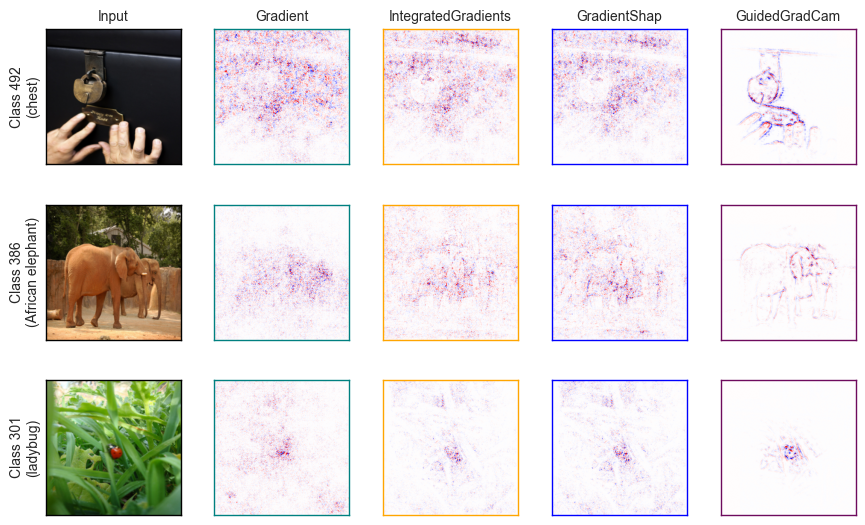

In [133]:
# Display multiple images with their explanations in a grid
indices = [i for i in range(len(x_batch[0]))]
ncols = 1 + len(explanations)
nrows = len(indices)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.8, nrows*1.8))

for row, index in enumerate(indices):
    # Original image
    img = quantus.normalise_func.denormalise(
        x_batch[index].cpu(), 
        mean=np.array([0.485, 0.456, 0.406]), 
        std=np.array([0.229, 0.224, 0.225])
    )
    img = np.clip(img, 0, 1)
    axes[row, 0].imshow(np.moveaxis(img, 0, -1))
    if include_titles and row == 0:
        axes[row, 0].set_title("Input", fontsize=10)
        
    class_id = y_batch[index].item()
    axes[row, 0].set_ylabel(f"Class {class_id}\n({index_to_label[class_id]})", fontsize=10)
    axes[row, 0].set_xticks([]); axes[row, 0].set_yticks([])

    for spine in axes[row, 0].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Explanation methods
    for i in range(1, ncols):
        xai = methods_order[i-1]
        
        norm_exp = quantus.normalise_func.normalise_by_negative(explanations[xai][index].reshape(224, 224))
        axes[row, i].imshow(norm_exp, cmap="seismic", vmin=-1.0, vmax=1.0)
        
        if include_titles and row == 0:
            axes[row, i].set_title(methods_order[i-1], fontsize=10)
        
        axes[row, i].set_xticks([]); axes[row, i].set_yticks([])
        
        # Frame styling with colored borders
        axes[row, i].grid(False)
        for spine in axes[row, i].spines.values():
            spine.set_color(colours_order[i-1])
            spine.set_linewidth(1)

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# Save as pdf
#plt.savefig("figures/ex2b_qualitative_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

From this visualisation alone (qualitative assessment), it is hard a decipher which explanation method to prefer or which is most helpful in the task of explaining the Imagenet class, and often subjective. The following analysis approaches this problem with quantitative metrics.

---

### Quantitative Analysis

### Quantus metrics parameters
- the results depend on the setting of the corresponding parameters of the metrics
- needs careful consideration

In [134]:
quantus.Sparseness().get_params

{'abs': True,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function mean at 0x000002623D80AEF0>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 '_disable_warnings': False,
 '_display_progressbar': False,
 'a_axes': None}

In [135]:
quantus.PixelFlipping().get_params # Try perturb_baseline='mean' instead of 'black', return_auc_per_sample=True,

{'abs': False,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function mean at 0x000002623D80AEF0>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 '_disable_warnings': False,
 '_display_progressbar': False,
 'a_axes': None,
 'features_in_step': 1,
 'return_auc_per_sample': False,
 'perturb_func': functools.partial(<function baseline_replacement_by_indices at 0x0000026272203EB0>, perturb_baseline='black')}

In [136]:
quantus.RelevanceMassAccuracy().get_params # Try default normalise=True

{'abs': False,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function mean at 0x000002623D80AEF0>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 '_disable_warnings': False,
 '_display_progressbar': False,
 'a_axes': None}

In [137]:
quantus.RandomLogit().get_params # By default su tieto opacne abs=True, normalise=False

{'abs': False,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function mean at 0x000002623D80AEF0>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 '_disable_warnings': False,
 '_display_progressbar': False,
 'a_axes': None,
 'similarity_func': <function quantus.functions.similarity_func.ssim(a: <built-in function array>, b: <built-in function array>, **kwargs) -> float>,
 'num_classes': 1000,
 'seed': 42}

In [138]:
quantus.LocalLipschitzEstimate().get_params

{'abs': False,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function mean at 0x000002623D80AEF0>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 '_disable_warnings': False,
 '_display_progressbar': False,
 'a_axes': None,
 'nr_samples': 200,
 'similarity_func': <function quantus.functions.similarity_func.lipschitz_constant(a: <built-in function array>, b: <built-in function array>, c: Optional[<built-in function array>], d: Optional[<built-in function array>], **kwargs) -> float>,
 'norm_numerator': <function quantus.functions.similarity_func.distance_euclidean(a: <built-in function array>, b: <built-in function array>, **kwargs) -> float>,
 'norm_denominator': <function quantus.functions.similarity_func.distance_euclidean(a: <built-in function array>, b: <built-in function array>, **kwargs) -> float>,
 'perturb_func': functools.partial(<function 

In [139]:
xai_methods = list(explanations.keys())

metrics = { 
    # ↑ better
    "Complexity":    quantus.Sparseness(abs=True, normalise=True, return_aggregate=True),                           
    # ↓ better
    "Faithfulness":  quantus.PixelFlipping(features_in_step=1024, abs=True, normalise=True, perturb_baseline='mean', return_aggregate=True),
    # ↑ better
    "Localisation":  quantus.RelevanceMassAccuracy(abs=True, normalise=False, return_aggregate=True),    
    # ↓ better                    
    "Randomisation": quantus.RandomLogit(num_classes=1000, abs=True, normalise=False, return_aggregate=True),   
    # ↓ better  
    "Robustness":    quantus.LocalLipschitzEstimate(nr_samples=10, perturb_std=0.2, return_aggregate=True),         
}

In [140]:
# convert to numpy
x_np = x_batch.detach().cpu().numpy()
y_np = y_batch.detach().cpu().numpy()
s_np = s_batch.detach().cpu().numpy()
if s_np.ndim == 3:
    s_np = s_np[:, None]

In [141]:
# Chunking configuration
chunk_map = {"Gradient": 16,
             "IntegratedGradients": 2,
             "GradientShap": 2,
             "GuidedGradCam":2
} # outer-batch sizes

def explain_chunked(model, inputs, targets, *, method, device, **kwargs):
    """Explains model predictions by chunking inputs and running explanations in batches."""
    # Convert NumPy → Tensor if needed
    x = torch.as_tensor(inputs,  device=device, dtype=torch.float32)
    y = torch.as_tensor(targets, device=device, dtype=torch.long)
    x = x.clone().detach().requires_grad_(True)

    # Per-method defaults (no duplicate keys possible)
    if method != "Gradient":
        kwargs.setdefault("n_steps", 32)
        kwargs.setdefault("internal_batch_size", 1)

    out = []
    step = chunk_map[method]
    for i in range(0, len(x), step):
        attr = quantus.explain(
            model,
            x[i:i+step],
            y[i:i+step],
            method=method,
            device=device,
            **kwargs
        )
        if isinstance(attr, torch.Tensor):
            attr = attr.detach().cpu().numpy()
        out.append(attr)
        torch.cuda.empty_cache()

    return np.concatenate(out, axis=0)

### Main Evaluation Loop
- calculate metrics' scores for each of the selected XAI attribution method
> **Beware:** computationally heavy for larger batches

In [142]:
results = {}
# start with guided grad cam
xai_methods = ["GuidedGradCam"] + [m for m in xai_methods if m != "GuidedGradCam"]

for method in xai_methods:
    results[method] = {}
    print(f"Method {method} ...")
    for name, metric in metrics.items():
        print(f"--{name}")
        if isinstance(metric, (quantus.Sparseness,
                               quantus.RelevanceMassAccuracy)):
            # reuse pre-computed explanations
            a_batch, expl_fn, expl_kw = explanations[method], None, layer_arg
        else:
            # force Quantus to call the safe adapter above
            a_batch = None
            expl_fn = explain_chunked
            expl_kw = dict(method=method, device=device, gc_layer=target_layer)

        scores = metric(
            model=model,
            x_batch=x_np,
            y_batch=y_np,
            a_batch=a_batch,
            s_batch=s_np,
            device=device,
            explain_func=expl_fn,
            explain_func_kwargs=expl_kw,
        )
        results[method][name] = scores
        gc.collect()

Method GuidedGradCam ...
--Complexity
--Faithfulness


c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


--Localisation
--Randomisation
--Robustness
Method Gradient ...
--Complexity
--Faithfulness
--Localisation
--Randomisation
--Robustness
Method IntegratedGradients ...
--Complexity
--Faithfulness
--Localisation
--Randomisation
--Robustness
Method GradientShap ...
--Complexity
--Faithfulness
--Localisation
--Randomisation
--Robustness


### Preprocess the obtained results
Before plotting the results (radar plot), dataframes are created, and data is processed with:
- aggregation
- scaling
- ranking 

In [143]:
# Aggregate scores across metrics
results_agg = {method: {} for method in xai_methods}
for method in xai_methods:
    for metric in metrics:
        results_agg[method][metric] = np.mean(results[method][metric])

# Create dataframe and normalize values
df = pd.DataFrame.from_dict(results_agg).T.abs()

# if lower is better, use inverse ranking
lower_better = ["Robustness", "Faithfulness", "Randomisation"]
df_normalised = pd.DataFrame(index=df.index)

for metric in df.columns:
    if metric in lower_better:
        # invert: smaller raw → bigger normalized
        df_normalised[metric] = df[metric].min() / df[metric]
    else:
        # higher raw → bigger normalized
        df_normalised[metric] = df[metric] / df[metric].max()


# Calculate ranks
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Complexity,Faithfulness,Localisation,Randomisation,Robustness
GuidedGradCam,4.0,4.0,4.0,1.0,4.0
Gradient,1.0,1.0,1.0,4.0,1.0
IntegratedGradients,2.0,2.0,2.0,3.0,3.0
GradientShap,3.0,3.0,3.0,2.0,2.0


In [144]:
import seaborn as sns

# Plotting configs
sns.set()
sns.set_style("whitegrid")
plt.rcParams['ytick.labelleft'] = True; plt.rcParams['xtick.labelbottom'] = True

In [145]:
def plot_radar_chart(df, title="XAI Method Relative Comparison"):
    """Plot a radar chart comparing XAI methods across multiple metrics."""
    labels = list(df.columns)
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    spoke_labels = labels
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    ordered_colors = ["#008080", "#FFA500", "#0000FF", "#6e0b5d"]
    
    for i, method in enumerate(df.index):
        row_values = df.loc[method].values.tolist()
        row_values += row_values[:1]
        ax.plot(angles, row_values, label=method, linewidth=2, color=ordered_colors[i])
        ax.fill(angles, row_values, alpha=0.12, color=ordered_colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.tick_params(axis='x')
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        angle_deg = np.degrees(angle)
        if 90 < angle_deg < 270:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')
    
    ax.set_xticklabels(spoke_labels, fontsize=14)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)
    ax.set_ylim(0, 1.05)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12) # bbox means bounding box: (x, y)
    ax.spines['polar'].set_visible(False)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    #plt.savefig('figures/ex2a_imagenet_xai_radar.pdf', format='pdf', bbox_inches="tight", dpi=300)
    return fig, ax

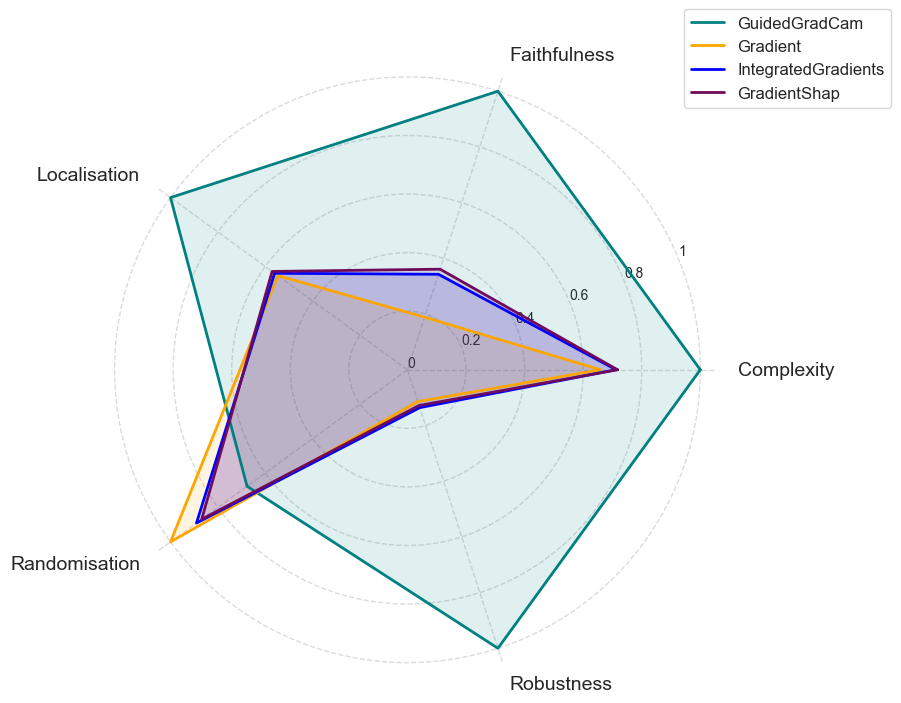

In [146]:
fig, ax = plot_radar_chart(df_normalised)
plt.show()

In [147]:
# Convert float values to integers
df_normalised_rank = df_normalised_rank.astype(int)

### Rank-based radar chart

In [148]:
# Convert float values to integers
df_normalised_rank = df_normalised_rank.astype(int)

# map rank -> radius : linear, center stays at zero
def _rank_to_radius(df_rank: pd.DataFrame, radius_max: float = 0.8) -> pd.DataFrame:
    max_rank = df_rank.to_numpy().max() # e.g. 3
    step = radius_max / max_rank        # distance per rank level
    return df_rank * step

In [149]:
def plot_radar_chart(df, title="XAI Method Relative Comparison"):
    """Creates a radar chart comparing XAI methods across different metrics."""
    labels = list(df.columns)
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    spoke_labels = labels
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    ordered_colors = ["#008080", "#FFA500", "#0000FF"] #, "#6e0b5d"]
    
    for i, method in enumerate(df.index):
        row_values = df.loc[method].values.tolist()
        row_values += row_values[:1]
        ax.plot(angles, row_values, label=method, linewidth=2, color=ordered_colors[i])
        ax.fill(angles, row_values, alpha=0.12, color=ordered_colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.tick_params(axis='x')
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        angle_deg = np.degrees(angle)
        if 90 < angle_deg < 270:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')
    
    ax.set_xticklabels(spoke_labels, fontsize=14)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)
    ax.set_ylim(0, 1.05)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12) 
    ax.spines['polar'].set_visible(False)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    #plt.savefig('figures/ex2a_mnist_xai_radar.pdf', format='pdf', bbox_inches="tight", dpi=300)
    return fig, ax

### Sensitivity Analysis

Various parameters can have a significant influence on the evaluation outcome. This section follows [Quantus](https://github.com/understandable-machine-intelligence-lab/Quantus/tree/main/tutorials)' analysis of how different explanations methods rank.

Metric analyzed: `Faithfulness Correlation`, by [Bhatt et al. 2020](https://arxiv.org/html/2502.03014v1).

In [151]:
# Define parameter settings to evaluate
baseline_strategies = ["mean", "uniform"]
subset_sizes = np.array([2, 52, 102])
sim_funcs = {
    "pearson": quantus.similarity_func.correlation_pearson, 
    "spearman": quantus.similarity_func.correlation_spearman
}
 
# Initialize results dictionary
result = {
    "Faithfulness score": [],
    "Method": [],
    "Similarity function": [],
    "Baseline strategy": [],
    "Subset size": [],
}

### Explanation evaluation with different settings
> **Note:** Beware, computationally expensive!

In [152]:
# Evaluate explanations with different parameter settings
for baseline in baseline_strategies:
    for subset_size in subset_sizes:
        for method, attr in explanations.items():
            for sim_name, sim_func in sim_funcs.items():
                metric = quantus.FaithfulnessCorrelation(
                    abs=True,
                    normalise=True,
                    return_aggregate=True,
                    disable_warnings=True,
                    aggregate_func=np.mean,
                    normalise_func=quantus.normalise_func.normalise_by_negative,
                    nr_runs=10,
                    perturb_baseline=baseline,
                    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
                    similarity_func=sim_func,
                    subset_size=subset_size
                )
                
                score = metric(
                    model=model.cuda(), 
                    x_batch=x_batch.cpu().numpy(), 
                    y_batch=y_batch.cpu().numpy(), 
                    a_batch=attr, 
                    device=device
                )
                
                result["Method"].append(method)
                result["Baseline strategy"].append(baseline.capitalize())
                result["Subset size"].append(subset_size)
                result["Faithfulness score"].append(score[0])
                result["Similarity function"].append(sim_name)

# Create DataFrame from results
df = pd.DataFrame(result)
df

,Faithfulness score,Method,Similarity function,Baseline strategy,Subset size
0,-0.078392,Gradient,pearson,Mean,2
1,0.010909,Gradient,spearman,Mean,2
2,-0.044824,IntegratedGradients,pearson,Mean,2
3,0.101818,IntegratedGradients,spearman,Mean,2
4,-0.007283,GradientShap,pearson,Mean,2
5,0.031515,GradientShap,spearman,Mean,2
6,0.038674,GuidedGradCam,pearson,Mean,2
7,0.067879,GuidedGradCam,spearman,Mean,2
8,0.113831,Gradient,pearson,Mean,52
9,-0.206061,Gradient,spearman,Mean,52


In [153]:
# Calculate ranks and prepare data for visualization
df["Rank"] = df.groupby(['Baseline strategy', 'Subset size', 'Similarity function'])["Faithfulness score"].rank()

# Clean column names
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns = [str(x).capitalize() for x in df.columns]

In [154]:
# Group by rank for visualization
df_view = df.groupby(["Method"])["Rank"].value_counts(normalize=True).mul(100).reset_index(name='Percentage').round(2)

# Order methods for visualization
df_view_ordered = pd.concat([
    df_view.loc[df_view["Method"] == 'Gradient'],
    df_view.loc[df_view["Method"] == 'GradientShap'], 
    df_view.loc[df_view["Method"] == 'IntegratedGradients'],
    df_view.loc[df_view["Method"] == 'GuidedGradCam']
], ignore_index=True)

C:\Users\simon\AppData\Local\Temp\ipykernel_30160\2179848900.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["G", "GS", "IG", "GGC"], fontsize=16) # "A", "B", "C", "D",


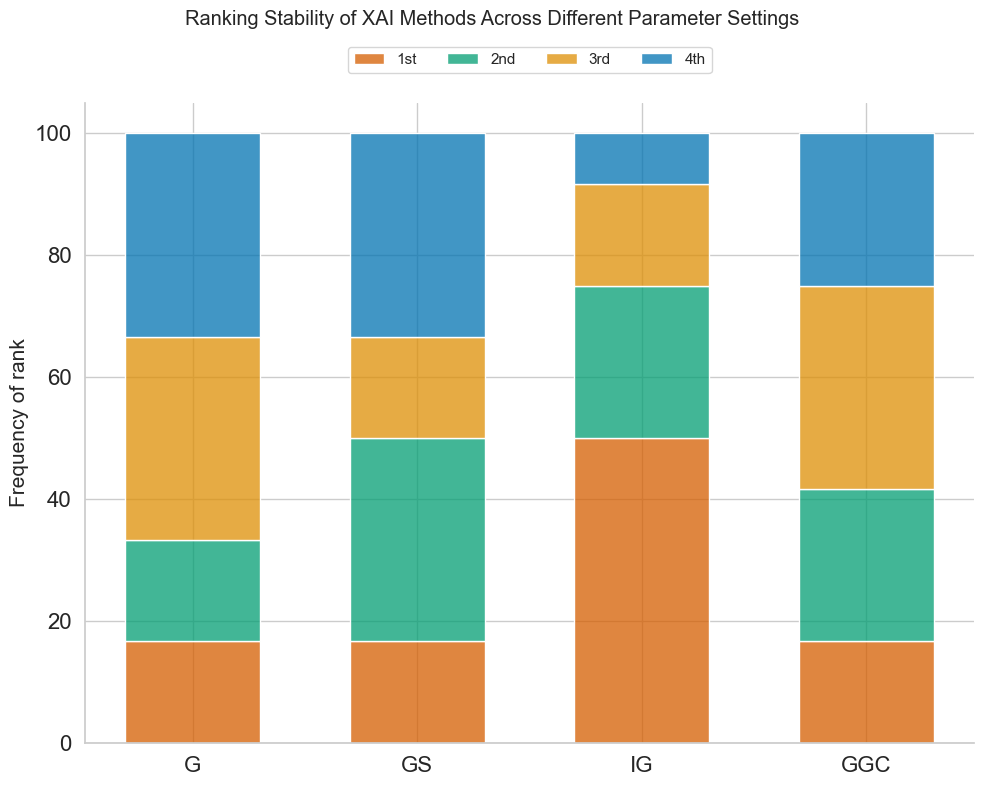

In [155]:
# Visualize the ranking distribution
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(
    x='Method', 
    hue='Rank', 
    weights='Percentage', 
    multiple='stack', 
    data=df_view_ordered, 
    shrink=0.6, 
    palette="colorblind", 
    legend=False,
    ax=ax
)

# Styling
ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Frequency of rank', fontsize=15)
ax.set_xlabel('')
ax.set_xticklabels(["G", "GS", "IG", "GGC"], fontsize=16) # "A", "B", "C", "D", 

# Add legend and divider
plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1), 
    ncol=5, 
    fancybox=True, 
    shadow=False, 
    labels=['1st', "2nd", "3rd", "4th"],
)
plt.suptitle("Ranking Stability of XAI Methods Across Different Parameter Settings")
plt.tight_layout()
#plt.savefig("quantus-imagenet-ranking.pdf", bbox_inches="tight", dpi=300)